In [1]:
import igraph as ig
import numpy as np
import pandas as pd
from IPython.core.display import display, SVG
import matplotlib.pyplot as plt
import umap
from scipy.special import comb as choose
import scipy.stats as ss
from itertools import groupby


In [2]:
def readGraph(fn, directed=False):
    g = ig.Graph.Read_Ncol(fn+'.edgelist',directed=directed)
    c = np.loadtxt(fn+'.community',dtype='uint8')
    node_base = min([int(x['name']) for x in g.vs]) ## graphs have 1-based or 0-based nodes 
    comm_base = min(c) ## same for communities
    comm = [c[int(x['name'])-node_base]-comm_base for x in g.vs]
    g.vs['community'] = comm
    g.vs['shape'] = 'circle'
    pal = ig.RainbowPalette(n=max(comm)+1)
    g.vs['color'] = [pal.get(int(i)) for i in comm]
    g.vs['size'] = 10
    g.es['width'] = 1
    return g

## Cliques

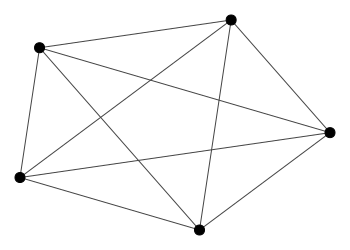

In [3]:
## 5-clique (fully connected)
g = ig.Graph.Erdos_Renyi(n=5,p=1)
g.vs['size']=10
g.vs['color']='black'
ig.plot(g, layout='kk', bbox=(0,0,350,250))

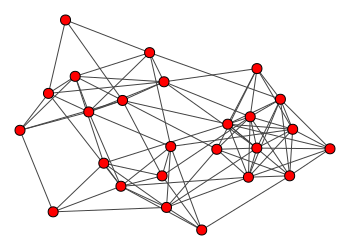

In [4]:
## PA model with 3 'classes'
# 根据顶点类型和连接分布产生图，n为顶点个数，type_dist为类型分布，pref_matrix为和各个类型节点的连接偏好
P = [[.8,.2,.1],[.2,.8,.15],[.1,.15,.8]]
g = ig.Graph.Preference(n=25,type_dist=[.33,.34,.33],pref_matrix=P,attribute='class')
g.vs['size']=10
ly = g.layout('fr')
ig.plot(g, layout=ly, bbox=(0,0,350,250))

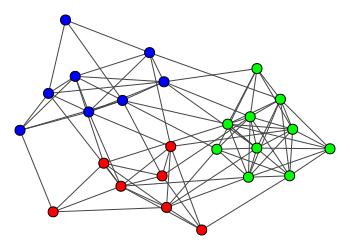

In [5]:
cl = ['red','blue','green']
g.vs['color']=[cl[i] for i in g.vs['class']]
ig.plot(g, layout=ly, bbox=(0,0,350,250))

there are 25 such cliques


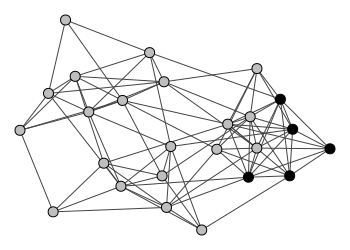

In [6]:
## any cliques?
C = g.cliques(min=5)
g.vs['color'] = 'grey'
print('there are',len(C),'such cliques')
## show one of the cliques
for i in C[0]:
    g.vs[i]['color'] = 'black'
ig.plot(g, layout=ly, bbox=(0,0,350,250))

## Coreness, k-cores

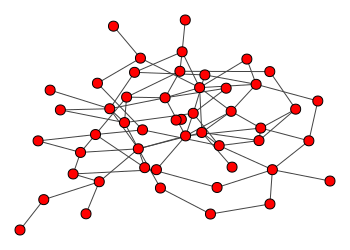

In [7]:
g = ig.Graph.Erdos_Renyi(n=50,m=80)
g.vs['size']=10
ig.plot(g, layout='kk', bbox=(0,0,350,250))

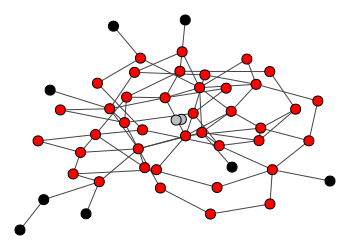

In [8]:
c = g.coreness()
cl = ['grey','black','red']
g.vs['color'] = [cl[min(i,2)] for i in c]
ig.plot(g, layout='kk', bbox=(0,0,350,250))

## Strong, weak communities

In [9]:
g = readGraph('Data/LFR15/lfr15')
#g = readGraph('Data/LFR35/lfr35')
#g = readGraph('Data/LFR55/lfr55')


In [10]:
## count degrees within communities
g.vs['in_deg'] = 0
for c in range (1+np.max(g.vs['community'])):
    v = [x for x in g.vs if x['community']==c]
    sg = g.subgraph(v)
    d = sg.degree()
    for i in range(len(d)):
        v[i]['in_deg'] = d[i]

In [11]:
D = pd.DataFrame({'community':g.vs['community'],
                  'degree':g.degree(),
                  'in_deg':g.vs['in_deg']})
D['ext_deg'] = D['degree'] - D['in_deg']
D['#strong'] = [int(i) for i in D['in_deg']>D['ext_deg']]
D['size'] = 1
D.groupby('community').sum()

,degree,in_deg,ext_deg,#strong,size
community,,,,,
0,136,114,22,16,16
1,119,100,19,17,17
2,50,44,6,9,9
3,114,94,20,16,17
4,174,148,26,20,20
5,79,68,11,11,11
6,56,50,6,10,10


## Spectral clustering, bissection

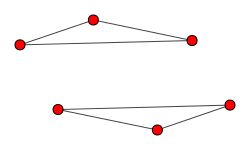

In [12]:
g = ig.Graph.Erdos_Renyi(n=6,m=0)
e = [(0,1),(0,2),(2,1),(3,4),(3,5),(5,4)]
for i in e:
    g.add_edge(i[0],i[1])
g.vs['size']=10
ig.plot(g, layout='fr', bbox=(0,0,250,150))

In [13]:
L = g.laplacian()
L

[[2, -1, -1, 0, 0, 0],
 [-1, 2, -1, 0, 0, 0],
 [-1, -1, 2, 0, 0, 0],
 [0, 0, 0, 2, -1, -1],
 [0, 0, 0, -1, 2, -1],
 [0, 0, 0, -1, -1, 2]]

In [14]:
np.set_printoptions(precision=3)  # 控制小数显示精度
np.linalg.eig(L)[0]

array([ 3.000e+00, -4.441e-16,  3.000e+00,  3.000e+00, -4.441e-16,
        3.000e+00])

In [15]:
np.linalg.eig(L)[1]

array([[ 0.816, -0.577,  0.293,  0.   ,  0.   ,  0.   ],
       [-0.408, -0.577, -0.807,  0.   ,  0.   ,  0.   ],
       [-0.408, -0.577,  0.513,  0.   ,  0.   ,  0.   ],
       [ 0.   ,  0.   ,  0.   ,  0.816, -0.577,  0.293],
       [ 0.   ,  0.   ,  0.   , -0.408, -0.577, -0.807],
       [ 0.   ,  0.   ,  0.   , -0.408, -0.577,  0.513]])

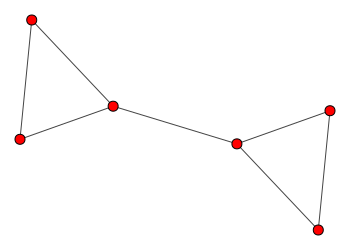

In [16]:
g.add_edge(0,3)
g.vs['size']=10
ig.plot(g, layout='fr', bbox=(0,0,350,250))

In [17]:
L = g.laplacian()
L

[[3, -1, -1, -1, 0, 0],
 [-1, 2, -1, 0, 0, 0],
 [-1, -1, 2, 0, 0, 0],
 [-1, 0, 0, 3, -1, -1],
 [0, 0, 0, -1, 2, -1],
 [0, 0, 0, -1, -1, 2]]

In [18]:
np.linalg.eigvals(L)

array([4.562e+00, 1.189e-16, 4.384e-01, 3.000e+00, 3.000e+00, 3.000e+00])

In [19]:
np.linalg.eig(L)[1]

array([[-0.657,  0.408,  0.261,  0.577,  0.146, -0.066],
       [ 0.185,  0.408,  0.465, -0.289, -0.751,  0.525],
       [ 0.185,  0.408,  0.465, -0.289,  0.605, -0.459],
       [ 0.657,  0.408, -0.261,  0.577,  0.146, -0.066],
       [-0.185,  0.408, -0.465, -0.289, -0.164, -0.469],
       [-0.185,  0.408, -0.465, -0.289,  0.017,  0.534]])

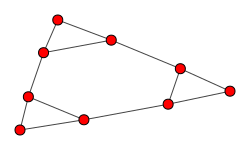

In [20]:
g = ig.Graph.Erdos_Renyi(n=9,m=0)
e = [(0,1),(0,2),(2,1),(3,4),(3,5),(5,4),(6,7),(6,8),(7,8),(0,3),(5,6),(1,8)]
for i in e:
    g.add_edge(i[0],i[1])
g.vs['size']=10
ig.plot(g, layout='fr', bbox=(0,0,250,150))

In [21]:
L = g.laplacian()
np.linalg.eigvals(L)

array([0.   , 5.   , 0.697, 0.697, 4.303, 4.303, 3.   , 3.   , 3.   ])

In [22]:
D = pd.DataFrame(np.linalg.eig(L)[1])
D

,0,1,2,3,4,5,6,7,8
0,-0.333333,-4.082483e-01,-0.400735,-0.141468,-0.532781,-0.066279,0.527046,-0.169490,-0.114953
1,-0.333333,4.082483e-01,-0.330885,-0.328316,0.040328,-0.522109,-0.105409,-0.398500,0.230842
2,-0.333333,-8.944505e-16,-0.561586,-0.360602,0.213852,0.255512,-0.421637,0.567990,-0.115889
3,-0.333333,4.082483e-01,-0.030333,0.363150,0.439914,0.352943,0.527046,-0.169490,-0.114953
4,-0.333333,8.088339e-16,0.130517,0.582285,-0.306719,0.031152,-0.421637,0.248543,0.588453
5,-0.333333,-4.082483e-01,0.200368,0.395437,0.266390,-0.424678,-0.105409,-0.079054,-0.473500
6,-0.333333,4.082483e-01,0.361218,-0.034834,-0.480242,0.169166,-0.105409,-0.079054,-0.473500
7,-0.333333,-2.867756e-17,0.431069,-0.221683,0.092867,-0.286664,0.210819,0.477554,0.242659
8,-0.333333,-4.082483e-01,0.200368,-0.253969,0.266390,0.490957,-0.105409,-0.398500,0.230842


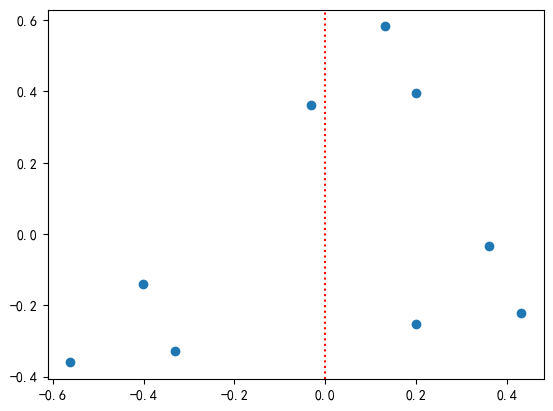

In [23]:
plt.figure()
x = D.iloc[:,2].tolist()
y = D.iloc[:,3].tolist()
plt.plot(x,y,'o')
plt.axvline(x=0, c='r', ls=':');
plt.show()

In [24]:
## k-means in 2D with k=2, 3 or 4 clusters
from sklearn.cluster import KMeans as km
print(km(2).fit(D.iloc[:,2:4]).labels_)
print(km(3).fit(D.iloc[:,2:4]).labels_)
print(km(4).fit(D.iloc[:,2:4]).labels_)


[1 1 1 0 0 0 0 0 0]
[1 1 1 0 0 0 2 2 2]
[1 1 3 2 2 2 0 0 0]


## Girvan Newman

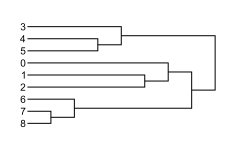

In [25]:
gn = g.community_edge_betweenness()
#pl = ig.plot(gn, bbox=(0,0,250,150))
#pl.save('gn-1.png') ## save the dendrogram
ig.plot(gn, bbox=(0,0,250,150))

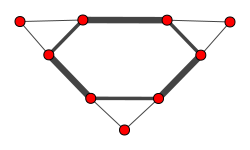

In [26]:
g.es['width'] = [x-3 for x in g.edge_betweenness()]
ig.plot(g, layout='fr', bbox=(0,0,250,150))

In [27]:
## cut dendrogram - 2 clusters
cl = gn.as_clustering(n=2)
print(cl.membership)
print(g.modularity(cl))

[0, 0, 0, 1, 1, 1, 0, 0, 0]
0.27777777777777773


In [28]:
## cut dendrogram - 3 clusters
cl = gn.as_clustering(n=3)
cl.membership

[0, 0, 0, 1, 1, 1, 2, 2, 2]

In [29]:
## optimal modularity
cl = gn.as_clustering()
print(cl.membership)
print(g.modularity(cl))


[0, 0, 0, 1, 1, 1, 2, 2, 2]
0.4166666666666667


## Planted Partition

* Matrix P encodes the edge probability between clusters (classes);
* for undirected graphs, upper triangle is used

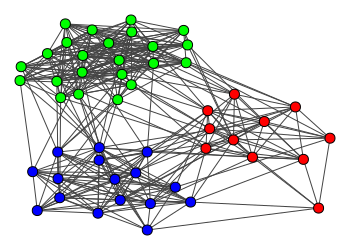

In [30]:
## Pin = .7, Pout=.1
P = [[.7,.1,.1],[.1,.7,.1],[.1,.1,.7]]
g = ig.Graph.Preference(n=50,type_dist=[.33,.34,.33],pref_matrix=P,attribute='class')
g.vs['size']=10
ly = g.layout('fr')
cl = ['red','blue','green']
g.vs['color']=[cl[i] for i in g.vs['class']]
ig.plot(g, layout=ly, bbox=(0,0,350,250))

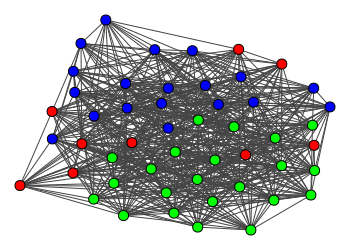

In [31]:
## Pin = .7, Pout=.4
P = [[.7,.4,.4],[.4,.7,.4],[.4,.4,.7]]
g = ig.Graph.Preference(n=50,type_dist=[.33,.34,.33],pref_matrix=P,attribute='class')
g.vs['size']=10
ly = g.layout('fr')
cl = ['red','blue','green']
g.vs['color']=[cl[i] for i in g.vs['class']]
ig.plot(g, layout=ly, bbox=(0,0,350,250))

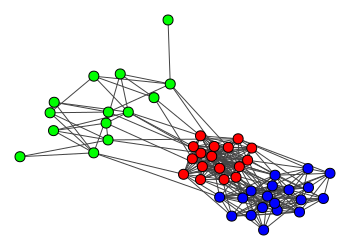

In [32]:
## Different P_{i,j}'s
P = [[.8,.1,.05],[.1,.5,.01],[.05,.01,.3]]
g = ig.Graph.Preference(n=50,type_dist=[.33,.34,.33],pref_matrix=P,attribute='class')
g.vs['size']=10
ly = g.layout('fr')
cl = ['red','blue','green']
g.vs['color']=[cl[i] for i in g.vs['class']]
ig.plot(g, layout=ly, bbox=(0,0,350,250))

## LFR Benchmark Graphs

* those were generated with the C code from GitHub
* we load the edge list and the community memberships


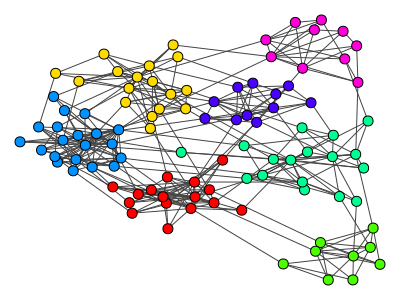

In [33]:
## mu = .15
g = readGraph('Data/LFR15/lfr15')
#g.vs['color'] = 'blue'
ly = g.layout("fr") 
ig.plot(g, layout=ly, bbox=(0,0,400,300))


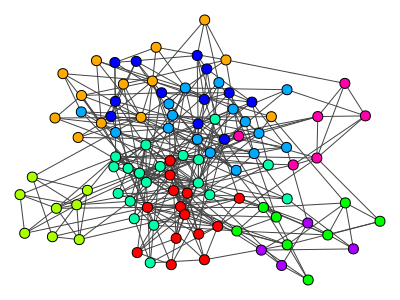

In [34]:
## mu = .35
g = readGraph('Data/LFR35/lfr35')
#g.vs['color'] = 'blue'
ly = g.layout("fr") 
ig.plot(g, layout=ly, bbox=(0,0,400,300))


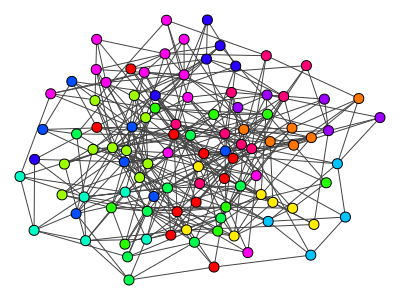

In [35]:
## mu = .55
g = readGraph('Data/LFR55/lfr55')
#g.vs['color'] = 'blue'
ly = g.layout("fr") 
ig.plot(g, layout=ly, bbox=(0,0,400,300))


## Modularity

In [36]:
g = ig.Graph.Erdos_Renyi(n=6,m=0)
e = [(0,1),(0,2),(2,1),(3,4),(3,5),(5,4),(0,3)]
for i in e:
    g.add_edge(i[0],i[1])
g.vs['size']=10
ly = g.layout('fr')
cl = ['black','red','blue','green','grey','cyan']

q = 0.3571428571428571


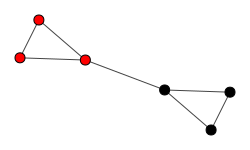

In [37]:
x = [0,0,0,0,0,0] ## single community
x = [0,1,2,3,4,5] ## all singletons
x = [0,0,0,0,1,1] ## suboptimal
x = [0,0,0,1,1,1] ## optimal

g.vs['color']=[cl[i] for i in x]
print('q =',g.modularity(x))
ig.plot(g, layout=ly, bbox=(0,0,250,150))


## Ring of Cliques

In [38]:
## ring of cliques igraph with n cliques of size m with e edges between contiguous cliques
import itertools
def ringOfCliques(n=24, m=5, e=1):
    size = n*m
    g = ig.Graph()
    for i in range(size):
        g.add_vertex(str(i))
    ## ring of cliques
    for i in range(0, size, m):
        ## cliques    
        for j in range(i,i+m-1,1):
            for k in range(j+1,i+m,1):
                g.add_edge(str(j),str(k),type='intra')
        ## ring
        if i>0:
            ## all pairs (i,i+1..i+m-1) and (i-m,i-m+1..i-m+m-1)
            a = np.arange(i,i+m,1)
            b = np.arange(i-m,i,1)
        else:
            a = np.arange(0,m,1)
            b = np.arange(size-m,size,1)
        ## all 2-ples: pick e
        l = list(itertools.product(a,b))
        arr = np.empty(len(l), dtype='O')
        arr[:] = l
        x = np.random.choice(arr,size=e,replace=False)
        for j in x:
            g.add_edge(str(j[0]),str(j[1]),type='extra')
    return(g)



In [39]:
## number of communities found with Louvain or CNM (modularity-based)
N = np.arange(4,49,4) ## number of 5-cliques
ML=[]
REP=10 ## take average
for n in N:
    ml=0
    for ctr in range(REP):
        g = ringOfCliques(n=n, m=5)
        ml = ml + max(g.community_multilevel().membership)+1
        #ml = ml + max(g.community_fastgreedy().as_clustering().membership)+1
    ML.append(ml/REP)


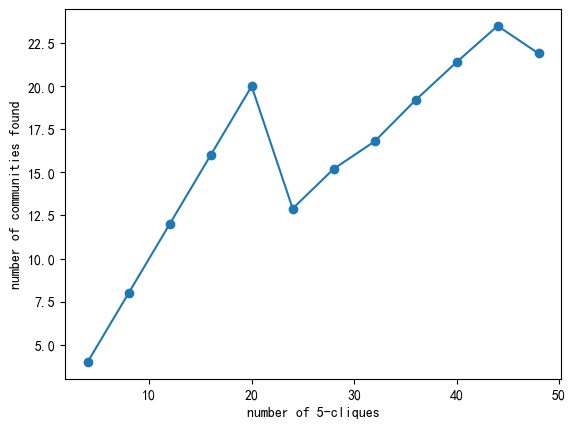

In [40]:
plt.figure()
plt.plot(N,ML,'o-')
plt.xlabel('number of 5-cliques')
plt.ylabel('number of communities found');
plt.show()

## Clustering algorithms

In [41]:
#g = readGraph('Data/LFR15/lfr15')
g = readGraph('Data/LFR35/lfr35')
#g = readGraph('Data/LFR55/lfr55')
print(max(set(g.vs['community'])),'communities')

8 communities


In [42]:
#c = g.community_edge_betweenness().as_clustering().membership
c = g.community_fastgreedy().as_clustering().membership
#c = g.community_multilevel().membership
#c = g.community_label_propagation().membership
#c = g.community_infomap().membership
#c = g.community_leading_eigenvector().membership
print(max(set(c)),'communities')
print('ARI =',ig.compare_communities(g.vs['community'],c,'adjusted_rand'))

6 communities
ARI = 0.7445329426251229
